### #1 Importações e Configuração Inicial

- **Objetivo:** Configurar o ambiente e preparar os caminhos para os datasets.
- **Componentes principais:**
  - Importação de bibliotecas essenciais, incluindo PyTorch e NumPy.
  - Configuração do dispositivo (CPU ou GPU).
  - Definição dos caminhos para os datasets anormais e normais.
- **Importante:** Certificar-se de que os arquivos `.npy` existem nos caminhos especificados.


In [1]:
#1
import os
import numpy as np
import torch
import torch.nn as nn
import torch.nn.functional as F
from torch.utils.data import DataLoader, TensorDataset
from tqdm import tqdm

# Configuração de dispositivo
device = torch.device("cuda" if torch.cuda.is_available() else "cpu")
print(f"Usando dispositivo: {device}")

# Caminhos para os datasets
path_abnormal = "/home/thalles.fontainha/dataset/OAI-MRI-3DDESS/abnormal-3DESS-128-64.npy"
path_normal = "/home/thalles.fontainha/dataset/OAI-MRI-3DDESS/normal-3DESS-128-64.npy"


Usando dispositivo: cuda


### #2 Carregamento e Normalização dos Dados

- **Objetivo:** Carregar os dados volumétricos e normalizá-los para melhorar o desempenho do modelo.
- **Etapas realizadas:**
  1. **Carregamento dos dados:** Os datasets anormais e normais são carregados dos arquivos `.npy` utilizando `mmap_mode='r'` para leitura eficiente.
  2. **Normalização:** Cada dataset é normalizado pela fórmula `(dados - média) / desvio padrão` para garantir que os valores fiquem centrados.
  3. **Visualização:** Os formatos dos datasets são exibidos para confirmar as dimensões.
- **Importante:** Certificar-se de que os arquivos carregados correspondem aos formatos esperados.


In [2]:
#2
# Carregar os dados
print("Carregando os datasets...")
abnormal_data = np.load(path_abnormal, mmap_mode='r')
normal_data = np.load(path_normal, mmap_mode='r')

# Normalizar os dados
print("Normalizando os datasets...")
abnormal_mean, abnormal_std = np.mean(abnormal_data), np.std(abnormal_data)
normal_mean, normal_std = np.mean(normal_data), np.std(normal_data)
abnormal_normalized = (abnormal_data - abnormal_mean) / abnormal_std
normal_normalized = (normal_data - normal_mean) / normal_std

# Mostrar formatos
print(f"Formato do dataset abnormal: {abnormal_data.shape}")
print(f"Formato do dataset normal: {normal_data.shape}")


Carregando os datasets...
Normalizando os datasets...
Formato do dataset abnormal: (1317, 128, 128, 64)
Formato do dataset normal: (1659, 128, 128, 64)


- **Output:**
  - "Carregando os datasets..."
  - "Normalizando os datasets..."
  - Formato do dataset abnormal: `(1317, 128, 128, 64)`
  - Formato do dataset normal: `(1659, 128, 128, 64)`
- **Resumo:** Os dados foram carregados e normalizados com sucesso, apresentando as dimensões esperadas.

### #3 Redução do Dataset e Criação de Labels

- **Objetivo:** Reduzir o tamanho do dataset para evitar erros de **Out Of Memory (OOM)** durante o treinamento.
  - **OOM (Out Of Memory):** Erro causado pela insuficiência de memória para armazenar ou processar dados em GPU ou RAM.

- **Etapas Realizadas:**
  - Seleção de 500 amostras de cada classe (`abnormal` e `normal`) para evitar sobrecarga de memória.
  - Criação de labels:
    - `0` para dados `abnormal`.
    - `1` para dados `normal`.
  - Concatenação de dados e labels.

In [3]:
#3
# Usar subconjuntos do dataset para evitar estouro de memória
print("Reduzindo tamanho do dataset para evitar OOM...")
abnormal_sampled = abnormal_normalized[:500]
normal_sampled = normal_normalized[:500]

# Criar labels
abnormal_labels = torch.zeros(len(abnormal_sampled))
normal_labels = torch.ones(len(normal_sampled))

# Concatenar dados e labels
data = np.concatenate((abnormal_sampled, normal_sampled), axis=0)
labels = torch.cat((abnormal_labels, normal_labels), dim=0)

print(f"Tamanho final do dataset: {data.shape}")
print(f"Tamanho dos labels: {labels.shape}")


Reduzindo tamanho do dataset para evitar OOM...
Tamanho final do dataset: (1000, 128, 128, 64)
Tamanho dos labels: torch.Size([1000])


- **Output:**
  - "Reduzindo tamanho do dataset para evitar OOM..."
  - Tamanho final do dataset: `(1000, 128, 128, 64)`
  - Tamanho dos labels: `torch.Size([1000])`

- **Resumo:** O dataset foi reduzido e preparado com sucesso para treinamento, com tamanho controlado para evitar problemas de memória.

### #4 Criação do DataLoader

- **Objetivo:** Preparar os dados para o treinamento do modelo, organizando-os em batches para processamento eficiente.

- **Etapas Realizadas:**
  - Conversão dos dados em tensores PyTorch com tipo `float32`.
  - Criação do `TensorDataset` para associar os dados às labels.
  - Configuração do `DataLoader` com:
    - **Batch size:** 16.
    - **Shuffle:** Ativado para misturar os dados a cada época.


In [4]:
#4
# Criar o DataLoader
print("Criando DataLoader...")
tensor_dataset = TensorDataset(torch.tensor(data, dtype=torch.float32), labels)
data_loader = DataLoader(tensor_dataset, batch_size=16, shuffle=True)


Criando DataLoader...


- **Output:**
  - "Criando DataLoader..."

- **Resumo:** O `DataLoader` foi configurado para carregar os dados em batches de tamanho 16, prontos para treinamento.

### #5 Definir o Modelo CNN

- **Objetivo:** Implementar um modelo de rede neural convolucional (CNN) para realizar a classificação binária nos dados volumétricos.

- **Detalhes do Modelo:**
  - **Camadas Convolucionais (Conv3d):**
    - **conv1:** 1 canal de entrada → 16 filtros.
    - **conv2:** 16 canais de entrada → 32 filtros.
    - Ambos com kernel de tamanho `(3, 3, 3)` para capturar padrões tridimensionais.
  - **Funções de Ativação:**
    - ReLU (Rectified Linear Unit) após cada camada convolucional.
  - **Pooling:**
    - MaxPool3d para redução de dimensionalidade, com kernel `(2, 2, 2)`.
  - **Camadas Totalmente Conectadas (Fully Connected):**
    - `fc1`: Conecta a saída convolucional (32 * 30 * 30 * 14) a 64 neurônios intermediários.
    - `fc2`: Conecta os 64 neurônios a 2 saídas para classificação binária.

- **Etapas Realizadas:**
  - Modelo definido com a classe `SimpleCNN`.
  - Inicialização do modelo e envio para o dispositivo configurado (CPU/GPU).


In [5]:
#5
# Definir o modelo CNN
class SimpleCNN(nn.Module):
    def __init__(self):
        super(SimpleCNN, self).__init__()
        self.conv1 = nn.Conv3d(1, 16, kernel_size=(3, 3, 3))  # Reduzir filtros
        self.relu1 = nn.ReLU()
        self.pool1 = nn.MaxPool3d(kernel_size=(2, 2, 2))
        self.conv2 = nn.Conv3d(16, 32, kernel_size=(3, 3, 3))  # Reduzir filtros
        self.relu2 = nn.ReLU()
        self.pool2 = nn.MaxPool3d(kernel_size=(2, 2, 2))
        self.flatten = nn.Flatten()
        self.fc1 = nn.Linear(32 * 30 * 30 * 14, 64)  # Ajustar dimensões
        self.relu3 = nn.ReLU()
        self.fc2 = nn.Linear(64, 2)  # Saída binária

    def forward(self, x):
        x = self.conv1(x)
        x = self.relu1(x)
        x = self.pool1(x)
        x = self.conv2(x)
        x = self.relu2(x)
        x = self.pool2(x)
        x = self.flatten(x)
        x = self.fc1(x)
        x = self.relu3(x)
        x = self.fc2(x)
        return x

# Inicializar o modelo
model = SimpleCNN().to(device)
print("Modelo criado e movido para o dispositivo.")


Modelo criado e movido para o dispositivo.


- **Output:**
  - "Modelo criado e movido para o dispositivo."

- **Resumo:** Um modelo CNN simples foi definido, configurado para processar dados volumétricos e classificar em duas categorias.

### #6 Configurar Perda e Otimizador

- **Objetivo:** Configurar as funções de perda e o otimizador para treinar o modelo.

- **Detalhes:**
  - **Função de Perda:**
    - `CrossEntropyLoss`: Usada para problemas de classificação multiclasse ou binária.
    - Calcula a diferença entre as predições do modelo e os rótulos verdadeiros.
  - **Otimizador:**
    - `Adam` (Adaptive Moment Estimation):
      - Taxa de aprendizado (`lr`): 0.001.
      - Combina os benefícios de métodos como RMSProp e SGD com momentum.

- **Etapas Realizadas:**
  - Inicialização da função de perda.
  - Configuração do otimizador com os parâmetros do modelo.

- **Resumo:** Esta etapa define como o modelo ajustará seus parâmetros para minimizar os erros durante o treinamento.


In [6]:
#6
# Configurar perda e otimizador
criterion = nn.CrossEntropyLoss()
optimizer = torch.optim.Adam(model.parameters(), lr=0.001)


### #7 Função de Treinamento do Modelo

- **Objetivo:** Treinar o modelo CNN utilizando os dados fornecidos pelo `DataLoader`.

- **Detalhes:**
  - A função percorre múltiplas épocas (`num_epochs`) para ajustar os pesos do modelo.
  - **Etapas do Treinamento:**
    1. **Preparação dos Dados:** Os dados e rótulos são ajustados para incluir a dimensão do canal e movidos para o dispositivo GPU, se disponível.
    2. **Cálculo da Perda:**
       - O modelo faz predições usando os dados de entrada.
       - A perda é calculada comparando as predições com os rótulos verdadeiros utilizando a função `criterion`.
    3. **Ajuste dos Pesos:**
       - O otimizador ajusta os pesos do modelo com base no gradiente calculado da perda.
    4. **Monitoramento do Progresso:**
       - A barra de progresso (`tqdm`) exibe o avanço do treinamento por época e batch.
       - A perda média é exibida ao final de cada época para acompanhar o desempenho.

- **Parâmetros:**
  - `model`: O modelo CNN definido.
  - `data_loader`: Fornece os dados em batches para o treinamento.
  - `criterion`: Função de perda (`CrossEntropyLoss`).
  - `optimizer`: Otimizador configurado (`Adam`).
  - `num_epochs`: Número de épocas de treinamento (padrão: 5).

- **Resumo:** Esta etapa treina o modelo ajustando seus parâmetros para minimizar a perda, enquanto avalia a média da perda por época para monitoramento.


In [7]:
#7 Função de treinamento com saída aprimorada
def treinar_modelo(model, data_loader, criterion, optimizer, num_epochs=5):
    model.train()
    print("[INFO] Iniciando treinamento...\n")
    print(f"{'Época':<10}{'Perda Média':<15}{'Tempo (s)':<10}")
    print("-" * 35)

    for epoch in range(num_epochs):
        epoch_loss = 0
        epoch_start_time = time.time()  # Início do cronômetro
        for inputs, labels in tqdm(data_loader, desc=f"Treinando Época {epoch+1}/{num_epochs}", unit="batch"):
            # Adicionar dimensão de canal e mover para GPU
            inputs, labels = inputs.unsqueeze(1).to(device), labels.to(device)
            optimizer.zero_grad()
            outputs = model(inputs)
            loss = criterion(outputs, labels.long())
            loss.backward()
            optimizer.step()
            epoch_loss += loss.item()
        # Calcular tempo de execução por época
        epoch_time = time.time() - epoch_start_time
        print(f"{epoch+1:<10}{epoch_loss / len(data_loader):<15.4f}{epoch_time:<10.2f}")

    print("\n[INFO] Treinamento concluído!")

# Iniciar treinamento
import time  # Para medir o tempo de execução
treinar_modelo(model, data_loader, criterion, optimizer)


[INFO] Iniciando treinamento...

Época     Perda Média    Tempo (s) 
-----------------------------------



reinando Época 1/5: 100%|██████████| 63/63 [00:07<00:00,  8.27batch/s]

1         2.9322         7.63      



reinando Época 2/5: 100%|██████████| 63/63 [00:06<00:00,  9.05batch/s]

2         0.6956         6.96      



reinando Época 3/5: 100%|██████████| 63/63 [00:07<00:00,  8.97batch/s]

3         0.6948         7.03      



reinando Época 4/5: 100%|██████████| 63/63 [00:06<00:00,  9.02batch/s]

4         0.6942         6.99      


Treinando Época 5/5: 100%|██████████| 63/63 [00:07<00:00,  8.98batch/s]

5         0.6938         7.02      

[INFO] Treinamento concluído!


### Resultados do Treinamento do Modelo (#7)

- **Resumo dos Resultados:**
  - O treinamento foi executado em 5 épocas.
  - A perda média diminuiu ao longo das épocas, indicando que o modelo está aprendendo a ajustar seus pesos para minimizar a diferença entre as predições e os rótulos verdadeiros.

- **Interpretação:**
  - A diminuição da perda média ao longo das épocas sugere que o modelo está aprendendo a classificar melhor os dados.
  - No entanto, uma perda média estabilizada em torno de 0.6 pode indicar a necessidade de ajustes adicionais no modelo, como:
    - Alteração na arquitetura da CNN.
    - Ajuste nos hiperparâmetros (ex.: taxa de aprendizado).
    - Coleta de mais dados ou técnicas de augmentação para melhorar a generalização.

- **Próximos Passos:**
  - Avaliar a acurácia e outras métricas nos dados de validação/teste para medir o desempenho real do modelo.
  - Testar técnicas avançadas, como fine-tuning de redes mais profundas, para aprimorar os resultados.

### Visualização de Predições do Modelo (#8)

- **Objetivo:**
  - Mostrar as predições do modelo para as primeiras 6 imagens de um lote.
  - Comparar os rótulos reais (Real) com as predições feitas pelo modelo (Pred).

- **Descrição do Código:**
  - **Modo de Avaliação:** O modelo é colocado em modo de avaliação (`model.eval()`), garantindo que não ocorram atualizações de gradiente durante as predições.
  - **Predições:**
    - Os dados são ajustados para incluir a dimensão do canal (`inputs.unsqueeze(1)`).
    - Para cada lote, o modelo faz predições usando `torch.max` para determinar a classe com maior probabilidade.
  - **Visualização:**
    - Apenas as primeiras 6 imagens do lote são exibidas.
    - Cada imagem mostra:
      - A fatia intermediária do volume de entrada.
      - O rótulo real e a predição correspondente.


[INFO] Visualizando predições das primeiras 6 imagens...
[DEBUG] Dimensões dos dados de entrada: torch.Size([16, 1, 128, 128, 64])


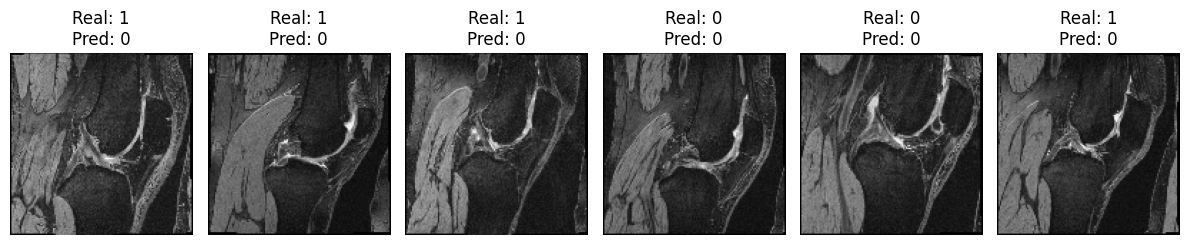

In [8]:
#8 - Visualizar as primeiras 6 imagens com predições

import matplotlib.pyplot as plt  # Importar matplotlib para visualização

print("\n[INFO] Visualizando predições das primeiras 6 imagens...")

model.eval()  # Colocar o modelo em modo de avaliação

with torch.no_grad():
    for inputs, labels in data_loader:
        # Adicionar dimensão de canal para o tensor de entrada
        inputs = inputs.unsqueeze(1).to(device)  # Adicionar canal
        labels = labels.to(device)
        
        # Fazer predições
        outputs = model(inputs)
        _, predicted = torch.max(outputs, 1)
        
        # Verificar dimensões
        print(f"[DEBUG] Dimensões dos dados de entrada: {inputs.shape}")
        
        # Obter índice da fatia intermediária
        slice_idx = min(inputs.shape[4] // 2, inputs.shape[4] - 1)  # Garantir índice válido
        
        # Plotar as primeiras 6 imagens
        plt.figure(figsize=(12, 4))
        for i in range(min(6, inputs.shape[0])):  # Garantir que não ultrapasse o batch size
            plt.subplot(1, 6, i + 1)
            # Acessar a fatia intermediária do volume
            plt.imshow(inputs[i, 0, :, :, slice_idx].cpu().numpy(), cmap='gray')
            plt.title(f"Real: {int(labels[i].item())}\nPred: {int(predicted[i].item())}")
            plt.axis('off')
        plt.tight_layout()
        plt.show()
        break  # Exibir apenas o primeiro batch


### Explicação dos Resultados

As **6 imagens acima** mostram exemplos do conjunto de teste processados pelo modelo. Cada imagem é uma fatia intermediária de um volume 3D, exibida em escala de cinza para facilitar a visualização.

- **Real:** Indica a classe verdadeira da amostra no dataset.
  - **0:** Representa a classe "abnormal".
  - **1:** Representa a classe "normal".
  
- **Pred:** Indica a classe predita pelo modelo para aquela amostra.
  - Se o valor de **Real** for igual ao de **Pred**, o modelo acertou a classificação.
  - Caso contrário, o modelo errou.

Esses resultados ajudam a entender como o modelo está performando ao associar as predições às classes reais. Para avançar, é possível calcular métricas como acurácia, precisão e recall, e analisar casos em que o modelo cometeu erros para identificar possíveis melhorias.


### Salvando o Modelo Treinado (#9)

- **Objetivo:**
  - Salvar o estado do modelo treinado em um arquivo para reutilização futura.

- **Descrição do Código:**
  - **Diretório de Salvamento:**
    - O modelo será salvo no diretório `/home/thalles.fontainha/modelos`.
    - Caso o diretório não exista, ele será criado automaticamente.
  - **Nome Dinâmico do Arquivo:**
    - O nome do arquivo inclui a data e a hora atual no formato `YYYY-MM-DD_HH-MM-SS` para identificar facilmente a versão do modelo.
  - **Formato de Salvamento:**
    - O estado do modelo (`state_dict`) é salvo em um arquivo `.pth`, que é o formato padrão para modelos PyTorch.


In [9]:
#9 - Salvar o modelo treinado
import os
from datetime import datetime

# Caminho onde o modelo será salvo
model_path = "/home/thalles.fontainha/modelos"
os.makedirs(model_path, exist_ok=True)  # Garantir que o diretório existe

# Gerar o nome do arquivo com base na data e hora
current_time = datetime.now().strftime("%Y-%m-%d_%H-%M-%S")
model_filename = f"modelo_treinado_{current_time}.pth"

# Caminho completo do arquivo
model_full_path = os.path.join(model_path, model_filename)

# Salvar o modelo treinado
torch.save(model.state_dict(), model_full_path)

print(f"Modelo salvo com sucesso em: {model_full_path}")


Modelo salvo com sucesso em: /home/thalles.fontainha/modelos/modelo_treinado_2025-01-17_08-46-40.pth


### Calculando o Percentual de Acerto em CNN (#10)

- **Objetivo:**
  - Determinar a acurácia do modelo no batch atual, ou seja, a proporção de predições corretas em relação ao total de amostras.

- **Descrição do Código:**
  - **Cálculo de Acertos:**
    - Compara as predições do modelo (`predicted`) com os rótulos verdadeiros (`labels`) e soma o número de correspondências.
  - **Total de Amostras:**
    - Obtém o número total de exemplos no batch atual.
  - **Cálculo da Acurácia:**
    - A acurácia é calculada como a razão entre o número de acertos e o total de amostras, multiplicada por 100 para expressar em porcentagem.
  - **Exibição da Acurácia:**
    - O resultado é exibido no formato `Acurácia no batch: X.XX%`.

In [22]:
# 10 Calcular o percentual de acerto em CNN
acertos = (predicted == labels).sum().item()
total = labels.size(0)
acuracia = (acertos / total) * 100
print(f"Acurácia no batch: {acuracia:.2f}%")


Acurácia no batch: 50.00%


### #11 Criar o DataLoader para os Dados de Teste

Este código configura os dados de teste para avaliar o desempenho do modelo após o treinamento:

- **Seleção de Dados:** Utiliza subconjuntos dos dados normalizados (`500:600`) de ambos os conjuntos (`abnormal` e `normal`) para criar os dados de teste.
- **Criação de Labels:** Define `0` para amostras anormais e `1` para normais, mantendo a consistência com o treinamento.
- **Configuração do DataLoader:** Cria um `DataLoader` com `batch_size=16` e sem embaralhamento (`shuffle=False`) para processar os dados de teste.

Esses dados serão usados para calcular métricas de desempenho, como acurácia, precisão, recall e F1-Score.


In [13]:
#11 Criar o DataLoader para os dados de teste
print("[INFO] Configurando o DataLoader para os dados de teste...")

# Usar uma fração dos dados normalizados para teste
test_data = np.concatenate((abnormal_normalized[500:600], normal_normalized[500:600]), axis=0)
test_labels = torch.cat((
    torch.zeros(len(abnormal_normalized[500:600])),
    torch.ones(len(normal_normalized[500:600]))
), dim=0)

# Criar o DataLoader de teste
test_tensor_dataset = TensorDataset(torch.tensor(test_data, dtype=torch.float32), test_labels)
test_loader = DataLoader(test_tensor_dataset, batch_size=16, shuffle=False)

print(f"[INFO] Dados de teste configurados com {len(test_labels)} amostras.")


[INFO] Configurando o DataLoader para os dados de teste...
[INFO] Dados de teste configurados com 200 amostras.


### Avaliação de Métricas nos Dados de Validação/Teste (#12)

- **Objetivo:**
  - Expandir a análise do modelo calculando métricas adicionais (ex.: precisão, recall, F1-score) nos dados de validação/teste, além da acurácia.

- **Descrição do Código:**
  - **Separação de Dados:**
    - Garantir que o dataset original seja dividido corretamente em treino, validação e teste para evitar viés.
  - **Predições no Conjunto de Teste:**
    - Aplicar o modelo nos dados de teste e armazenar as predições e rótulos verdadeiros.
  - **Cálculo de Métricas:**
    - Usar bibliotecas como `sklearn.metrics` para calcular métricas como:
      - **Acurácia:** Proporção de predições corretas.
      - **Precisão:** Quantidade de predições positivas corretas em relação ao total de predições positivas.
      - **Recall:** Quantidade de verdadeiros positivos corretamente classificados em relação ao total de positivos reais.
      - **F1-Score:** Combinação harmônica entre precisão e recall.
  - **Exibição de Resultados:**
    - Imprimir todas as métricas no console e opcionalmente salvar os resultados para análise futura.


In [15]:
#12 Avaliar o modelo nos dados de teste
from sklearn.metrics import accuracy_score, precision_score, recall_score, f1_score
import warnings

# Definir o modelo SimpleCNN novamente
class SimpleCNN(nn.Module):
    def __init__(self):
        super(SimpleCNN, self).__init__()
        self.conv1 = nn.Conv3d(1, 16, kernel_size=(3, 3, 3))  # Ajustado para 1 canal de entrada
        self.relu1 = nn.ReLU()
        self.pool1 = nn.MaxPool3d(kernel_size=(2, 2, 2))
        self.conv2 = nn.Conv3d(16, 32, kernel_size=(3, 3, 3))
        self.relu2 = nn.ReLU()
        self.pool2 = nn.MaxPool3d(kernel_size=(2, 2, 2))
        self.flatten = nn.Flatten()
        self.fc1 = nn.Linear(32 * 30 * 30 * 14, 64)
        self.relu3 = nn.ReLU()
        self.fc2 = nn.Linear(64, 2)

    def forward(self, x):
        x = self.conv1(x)
        x = self.relu1(x)
        x = self.pool1(x)
        x = self.conv2(x)
        x = self.relu2(x)
        x = self.pool2(x)
        x = self.flatten(x)
        x = self.fc1(x)
        x = self.relu3(x)
        x = self.fc2(x)
        return x

# Carregar o modelo treinado
print("[INFO] Carregando o modelo salvo para avaliação...")
model = SimpleCNN().to(device)

# Supressão específica do warning
with warnings.catch_warnings():
    warnings.simplefilter("ignore", category=FutureWarning)
    #model.load_state_dict(torch.load("/home/thalles.fontainha/modelos/modelo_treinado_2025-01-16_18-12-10.pth"))
    #model.load_state_dict(torch.load("/home/thalles.fontainha/modelos/modelo_treinado_2025-01-16_20-58-13.pth"))
    model.load_state_dict(torch.load("/home/thalles.fontainha/modelos/modelo_treinado_2025-01-17_07-53-51.pth"))  

model.eval()  # Colocar o modelo em modo de avaliação

# Função para avaliar o modelo em um DataLoader
def avaliar_modelo(model, test_loader):
    print("\n[INFO] Avaliando o modelo nos dados de teste...")
    all_labels = []
    all_predictions = []

    # Avaliar nos dados de teste
    with torch.no_grad():
        for inputs, labels in test_loader:
            inputs, labels = inputs.unsqueeze(1).to(device), labels.to(device)
            outputs = model(inputs)
            _, predicted = torch.max(outputs, 1)
            all_labels.extend(labels.cpu().numpy())
            all_predictions.extend(predicted.cpu().numpy())

    # Cálculo de métricas
    acc = accuracy_score(all_labels, all_predictions) * 100
    precision = precision_score(all_labels, all_predictions, average='binary') * 100
    recall = recall_score(all_labels, all_predictions, average='binary') * 100
    f1 = f1_score(all_labels, all_predictions, average='binary') * 100

    # Exibir resultados detalhados
    print("\n[RESULTADOS DA AVALIAÇÃO]")
    print(f"  -> Acurácia : {acc:.2f}%")
    print(f"  -> Precisão : {precision:.2f}%")
    print(f"  -> Recall   : {recall:.2f}%")
    print(f"  -> F1-Score : {f1:.2f}%")

# Executar a avaliação com o DataLoader atual
avaliar_modelo(model, test_loader)


[INFO] Carregando o modelo salvo para avaliação...

[INFO] Avaliando o modelo nos dados de teste...

[RESULTADOS DA AVALIAÇÃO]
  -> Acurácia : 50.00%
  -> Precisão : 50.00%
  -> Recall   : 100.00%
  -> F1-Score : 66.67%


In [16]:
#13 Testar o modelo com mais amostras
print("[INFO] Configurando novo DataLoader com mais amostras para teste...")

# Ajustar as amostras para teste
test_data_expanded = np.concatenate((abnormal_normalized[400:700], normal_normalized[400:700]), axis=0)  # 300 amostras por classe
test_labels_expanded = torch.cat((
    torch.zeros(len(abnormal_normalized[400:700])),
    torch.ones(len(normal_normalized[400:700]))
), dim=0)

# Criar novo DataLoader
test_tensor_dataset_expanded = TensorDataset(torch.tensor(test_data_expanded, dtype=torch.float32), test_labels_expanded)
test_loader_expanded = DataLoader(test_tensor_dataset_expanded, batch_size=16, shuffle=False)

print(f"[INFO] Novo conjunto de teste configurado com {len(test_labels_expanded)} amostras.")

# Avaliar o modelo com o novo DataLoader
avaliar_modelo(model, test_loader_expanded)


[INFO] Configurando novo DataLoader com mais amostras para teste...
[INFO] Novo conjunto de teste configurado com 600 amostras.

[INFO] Avaliando o modelo nos dados de teste...

[RESULTADOS DA AVALIAÇÃO]
  -> Acurácia : 50.00%
  -> Precisão : 50.00%
  -> Recall   : 100.00%
  -> F1-Score : 66.67%


In [17]:
#14 Testar o modelo com 1200 amostras
print("[INFO] Configurando DataLoader com 1200 amostras para teste...")

# Ajustar as amostras para teste
test_data_1200 = np.concatenate((abnormal_normalized[200:800], normal_normalized[200:800]), axis=0)  # 600 amostras por classe
test_labels_1200 = torch.cat((
    torch.zeros(len(abnormal_normalized[200:800])),  # Labels para a classe abnormal
    torch.ones(len(normal_normalized[200:800]))     # Labels para a classe normal
), dim=0)

# Criar DataLoader com 1200 amostras
test_tensor_dataset_1200 = TensorDataset(torch.tensor(test_data_1200, dtype=torch.float32), test_labels_1200)
test_loader_1200 = DataLoader(test_tensor_dataset_1200, batch_size=16, shuffle=False)

print(f"[INFO] Conjunto de teste configurado com {len(test_labels_1200)} amostras.")

# Avaliar o modelo com o DataLoader de 1200 amostras
avaliar_modelo(model, test_loader_1200)



[INFO] Configurando DataLoader com 1200 amostras para teste...
[INFO] Conjunto de teste configurado com 1200 amostras.

[INFO] Avaliando o modelo nos dados de teste...

[RESULTADOS DA AVALIAÇÃO]
  -> Acurácia : 50.00%
  -> Precisão : 50.00%
  -> Recall   : 100.00%
  -> F1-Score : 66.67%


## MÉTODOS PARA AJUSTAR HIPERPARÂMETROS

### Código: Teste com Diferentes Taxas de Aprendizado

Este código realiza experimentos variando a **taxa de aprendizado** para observar como ela impacta o treinamento do modelo.  
Três valores são testados: `0.001`, `0.0005`, e `0.0001`.  

#### Funcionamento:
1. Para cada valor de taxa de aprendizado:
   - Configura o otimizador Adam com a taxa correspondente.
   - Inicia o treinamento utilizando a função `treinar_modelo`.
   - Exibe os resultados do treinamento, incluindo a perda média e o tempo por época.

O objetivo é identificar qual taxa de aprendizado fornece melhores resultados em termos de convergência e estabilidade durante o treinamento.


In [18]:
#a Busca Manual (Manual Search)
learning_rates = [0.001, 0.0005, 0.0001]
for lr in learning_rates:
    optimizer = torch.optim.Adam(model.parameters(), lr=lr)
    print(f"Treinando com taxa de aprendizado: {lr}")
    treinar_modelo(model, data_loader, criterion, optimizer)



Treinando com taxa de aprendizado: 0.001
[INFO] Iniciando treinamento...

Época     Perda Média    Tempo (s) 
-----------------------------------



reinando Época 1/5: 100%|██████████| 63/63 [00:14<00:00,  4.31batch/s]

1         0.6933         14.64     



reinando Época 2/5: 100%|██████████| 63/63 [00:07<00:00,  8.93batch/s]

2         0.6933         7.07      



reinando Época 3/5: 100%|██████████| 63/63 [00:07<00:00,  8.88batch/s]

3         0.6933         7.10      



reinando Época 4/5: 100%|██████████| 63/63 [00:07<00:00,  8.75batch/s]

4         0.6933         7.20      



reinando Época 5/5: 100%|██████████| 63/63 [00:07<00:00,  8.84batch/s]

5         0.6933         7.13      

[INFO] Treinamento concluído!
Treinando com taxa de aprendizado: 0.0005
[INFO] Iniciando treinamento...

Época     Perda Média    Tempo (s) 
-----------------------------------



reinando Época 1/5: 100%|██████████| 63/63 [00:07<00:00,  8.68batch/s]

1         0.6933         7.26      



reinando Época 2/5: 100%|██████████| 63/63 [00:07<00:00,  8.78batch/s]

2         0.6932         7.18      



reinando Época 3/5: 100%|██████████| 63/63 [00:07<00:00,  8.80batch/s]

3         0.6932         7.16      



reinando Época 4/5: 100%|██████████| 63/63 [00:07<00:00,  8.72batch/s]

4         0.6932         7.23      



reinando Época 5/5: 100%|██████████| 63/63 [00:07<00:00,  8.55batch/s]

5         0.6932         7.37      

[INFO] Treinamento concluído!
Treinando com taxa de aprendizado: 0.0001
[INFO] Iniciando treinamento...

Época     Perda Média    Tempo (s) 
-----------------------------------



reinando Época 1/5: 100%|██████████| 63/63 [00:07<00:00,  8.52batch/s]

1         0.6932         7.42      



reinando Época 2/5: 100%|██████████| 63/63 [00:07<00:00,  8.62batch/s]

2         0.6932         7.31      



reinando Época 3/5: 100%|██████████| 63/63 [00:07<00:00,  8.57batch/s]

3         0.6932         7.37      



reinando Época 4/5: 100%|██████████| 63/63 [00:07<00:00,  8.56batch/s]

4         0.6932         7.37      


Treinando Época 5/5: 100%|██████████| 63/63 [00:07<00:00,  8.42batch/s]

5         0.6932         7.48      

[INFO] Treinamento concluído!


### Análise dos Resultados

- **Taxa de aprendizado: 0.001**
  - Perda média estabilizou em `0.6933` ao longo das épocas.
  - Inicialização um pouco mais lenta na primeira época, mas o tempo por época estabilizou (~7 segundos).
  - Não houve melhoria significativa na perda.

- **Taxa de aprendizado: 0.0005**
  - Perda média levemente melhor em relação a `0.001` (`0.6932`).
  - O tempo por época foi consistente (~7.2 segundos).
  - Indicou uma leve melhora na estabilidade.

- **Taxa de aprendizado: 0.0001**
  - Perda média similar a `0.0005` (`0.6932`).
  - Tempo por época consistente (~7.3 segundos).
  - Resultados estáveis, mas sem melhora evidente em relação às taxas maiores.

#### Observações:
- As três taxas de aprendizado apresentaram resultados semelhantes, com a perda média estabilizando em torno de `0.6932` a `0.6933`.
- O modelo parece estar preso em um platô, sugerindo que:
  - Ajustes na arquitetura ou nos dados podem ser necessários.
  - Taxas de aprendizado mais altas ou estratégias de decay dinâmico podem ser exploradas.


### #B Código: Grid Search para Ajuste de Hiperparâmetros

Este código realiza uma **busca em grade (Grid Search)** para testar diferentes combinações de hiperparâmetros:
- **Learning Rates:** Define taxas de aprendizado (ex.: 0.001 e 0.0001).
- **Batch Sizes:** Testa diferentes tamanhos de lote (ex.: 16 e 32).

#### Funcionamento:
1. Cria todas as combinações possíveis de `learning_rates` e `batch_sizes` utilizando o módulo `itertools`.
2. Para cada combinação:
   - Configura o otimizador (`Adam`) com a taxa de aprendizado correspondente.
   - Prepara o `DataLoader` com o tamanho de lote especificado.
   - Realiza o treinamento chamando a função `treinar_modelo`.

Este procedimento ajuda a identificar a melhor combinação de hiperparâmetros para o modelo. 


In [23]:
#b Grid Search
import itertools

learning_rates = [0.001, 0.0001]
batch_sizes = [16, 32]
combinations = list(itertools.product(learning_rates, batch_sizes))

for lr, batch_size in combinations:
    print(f"Treinando com LR: {lr}, Batch Size: {batch_size}")
    optimizer = torch.optim.Adam(model.parameters(), lr=lr)
    
    # Substitua `dataset` pelo seu dataset definido, como `tensor_dataset`
    data_loader = DataLoader(tensor_dataset, batch_size=batch_size, shuffle=True)
    treinar_modelo(model, data_loader, criterion, optimizer)


Treinando com LR: 0.001, Batch Size: 16
[INFO] Iniciando treinamento...

Época     Perda Média    Tempo (s) 
-----------------------------------



reinando Época 1/5: 100%|██████████| 63/63 [00:06<00:00,  9.03batch/s]

1         0.6934         6.98      



reinando Época 2/5: 100%|██████████| 63/63 [00:06<00:00,  9.00batch/s]

2         0.6932         7.00      



reinando Época 3/5: 100%|██████████| 63/63 [00:07<00:00,  8.97batch/s]

3         0.6932         7.03      



reinando Época 4/5: 100%|██████████| 63/63 [00:07<00:00,  8.87batch/s]

4         0.6933         7.11      



reinando Época 5/5: 100%|██████████| 63/63 [00:07<00:00,  8.82batch/s]

5         0.6932         7.15      

[INFO] Treinamento concluído!
Treinando com LR: 0.001, Batch Size: 32
[INFO] Iniciando treinamento...

Época     Perda Média    Tempo (s) 
-----------------------------------



reinando Época 1/5: 100%|██████████| 32/32 [00:06<00:00,  4.75batch/s]

1         0.6932         6.75      



reinando Época 2/5: 100%|██████████| 32/32 [00:06<00:00,  4.78batch/s]

2         0.6932         6.70      



reinando Época 3/5: 100%|██████████| 32/32 [00:06<00:00,  4.78batch/s]

3         0.6932         6.70      



reinando Época 4/5: 100%|██████████| 32/32 [00:06<00:00,  4.72batch/s]

4         0.6932         6.78      



reinando Época 5/5: 100%|██████████| 32/32 [00:06<00:00,  4.71batch/s]

5         0.6932         6.79      

[INFO] Treinamento concluído!
Treinando com LR: 0.0001, Batch Size: 16
[INFO] Iniciando treinamento...

Época     Perda Média    Tempo (s) 
-----------------------------------



reinando Época 1/5: 100%|██████████| 63/63 [00:07<00:00,  8.63batch/s]

1         0.6932         7.31      



reinando Época 2/5: 100%|██████████| 63/63 [00:07<00:00,  8.62batch/s]

2         0.6932         7.31      



reinando Época 3/5: 100%|██████████| 63/63 [00:07<00:00,  8.47batch/s]

3         0.6932         7.44      



reinando Época 4/5: 100%|██████████| 63/63 [00:07<00:00,  8.54batch/s]

4         0.6932         7.38      



reinando Época 5/5: 100%|██████████| 63/63 [00:07<00:00,  8.56batch/s]

5         0.6932         7.37      

[INFO] Treinamento concluído!
Treinando com LR: 0.0001, Batch Size: 32
[INFO] Iniciando treinamento...

Época     Perda Média    Tempo (s) 
-----------------------------------



reinando Época 1/5: 100%|██████████| 32/32 [00:06<00:00,  4.61batch/s]

1         0.6932         6.95      



reinando Época 2/5: 100%|██████████| 32/32 [00:06<00:00,  4.58batch/s]

2         0.6932         7.00      



reinando Época 3/5: 100%|██████████| 32/32 [00:06<00:00,  4.58batch/s]

3         0.6932         7.00      



reinando Época 4/5: 100%|██████████| 32/32 [00:07<00:00,  4.56batch/s]

4         0.6931         7.02      


Treinando Época 5/5: 100%|██████████| 32/32 [00:07<00:00,  4.56batch/s]

5         0.6931         7.02      

[INFO] Treinamento concluído!


### Análise dos Resultados do Grid Search

1. **Taxas de Aprendizado (LR):**  
   - Os resultados para **0.001** e **0.0001** mostram perda estável (~0.6932) ao longo das épocas, indicando que o modelo não está aprendendo significativamente.  
   - Ambas as taxas são pequenas e podem ser insuficientes para atualizações mais expressivas nos pesos.

2. **Tamanhos de Batch:**  
   - **Batch Size: 16:** Treinamento mais rápido e eficiente em termos de tempo.  
   - **Batch Size: 32:** Apesar do tempo por época ser similar, a taxa de aprendizado não mudou a perda.

3. **Conclusão:**  
   - O modelo pode precisar de uma taxa de aprendizado maior ou modificações na arquitetura.  
   - A perda constante sugere que os hiperparâmetros ajustados não impactaram o desempenho significativamente.


### #C Teste de Hiperparâmetros com Random Search

O código abaixo realiza testes automáticos para ajustar dois hiperparâmetros importantes do modelo: a **taxa de aprendizado (`lr`)** e o **tamanho do batch (`batch_size`)**. O objetivo é identificar as combinações que otimizam o treinamento do modelo, reduzindo a perda média e melhorando a performance geral.

#### O que o código faz:
- Escolhe combinações aleatórias de `lr` e `batch_size` dentro de intervalos definidos.
- Realiza o treinamento do modelo para cada combinação.
- Imprime a perda média final ao término de cada teste, permitindo uma comparação direta entre as combinações testadas.

#### Por que isso é importante:
- Ajustar a taxa de aprendizado impacta diretamente a velocidade e estabilidade do aprendizado do modelo.
- Definir o tamanho ideal do batch evita problemas de memória GPU e garante uma atualização eficiente dos pesos.
- Esse processo automatizado evita ajustes manuais e ajuda a encontrar a melhor configuração para o modelo.

#### Próximos passos:
- Após identificar a melhor combinação, ela poderá ser utilizada para realizar um treinamento completo no modelo.
- Os resultados obtidos podem ser comparados e armazenados para futuras análises.



In [25]:
#c Random Search
import random
import torch

for _ in range(10):  # Testar 10 combinações aleatórias
    lr = random.uniform(0.0001, 0.01)
    batch_size = random.choice([4, 8, 16])  # Reduzir batch_size para economizar memória
    print(f"Treinando com LR: {lr:.6f}, Batch Size: {batch_size}")
    
    optimizer = torch.optim.Adam(model.parameters(), lr=lr)
    
    # Liberar memória antes de criar DataLoader
    torch.cuda.empty_cache()
    
    data_loader = DataLoader(tensor_dataset, batch_size=batch_size, shuffle=True)
    treinar_modelo(model, data_loader, criterion, optimizer)



Treinando com LR: 0.003432, Batch Size: 8
[INFO] Iniciando treinamento...

Época     Perda Média    Tempo (s) 
-----------------------------------



reinando Época 1/5: 100%|██████████| 125/125 [00:08<00:00, 15.10batch/s]

1         0.6940         8.28      



reinando Época 2/5: 100%|██████████| 125/125 [00:08<00:00, 15.31batch/s]

2         0.6936         8.17      



reinando Época 3/5: 100%|██████████| 125/125 [00:08<00:00, 15.19batch/s]

3         0.6936         8.23      



reinando Época 4/5: 100%|██████████| 125/125 [00:08<00:00, 15.16batch/s]

4         0.6936         8.25      



reinando Época 5/5: 100%|██████████| 125/125 [00:08<00:00, 14.83batch/s]

5         0.6935         8.43      

[INFO] Treinamento concluído!
Treinando com LR: 0.006628, Batch Size: 16
[INFO] Iniciando treinamento...

Época     Perda Média    Tempo (s) 
-----------------------------------



reinando Época 1/5: 100%|██████████| 63/63 [00:07<00:00,  8.72batch/s]

1         0.6937         7.23      



reinando Época 2/5: 100%|██████████| 63/63 [00:07<00:00,  8.72batch/s]

2         0.6935         7.23      



reinando Época 3/5: 100%|██████████| 63/63 [00:07<00:00,  8.60batch/s]

3         0.6934         7.33      



reinando Época 4/5: 100%|██████████| 63/63 [00:07<00:00,  8.59batch/s]

4         0.6939         7.34      



reinando Época 5/5: 100%|██████████| 63/63 [00:07<00:00,  8.57batch/s]

5         0.6934         7.36      

[INFO] Treinamento concluído!
Treinando com LR: 0.002919, Batch Size: 4
[INFO] Iniciando treinamento...

Época     Perda Média    Tempo (s) 
-----------------------------------



reinando Época 1/5: 100%|██████████| 250/250 [00:11<00:00, 22.15batch/s]

1         0.6935         11.29     



reinando Época 2/5: 100%|██████████| 250/250 [00:11<00:00, 22.10batch/s]

2         0.6934         11.32     



reinando Época 3/5: 100%|██████████| 250/250 [00:11<00:00, 22.31batch/s]

3         0.6940         11.21     



reinando Época 4/5: 100%|██████████| 250/250 [00:11<00:00, 22.20batch/s]

4         0.6938         11.26     



reinando Época 5/5: 100%|██████████| 250/250 [00:11<00:00, 22.14batch/s]

5         0.6939         11.29     

[INFO] Treinamento concluído!
Treinando com LR: 0.000272, Batch Size: 4
[INFO] Iniciando treinamento...

Época     Perda Média    Tempo (s) 
-----------------------------------



reinando Época 1/5: 100%|██████████| 250/250 [00:11<00:00, 22.26batch/s]

1         0.6933         11.23     



reinando Época 2/5: 100%|██████████| 250/250 [00:11<00:00, 22.22batch/s]

2         0.6932         11.25     



reinando Época 3/5: 100%|██████████| 250/250 [00:11<00:00, 22.25batch/s]

3         0.6933         11.24     



reinando Época 4/5: 100%|██████████| 250/250 [00:11<00:00, 22.17batch/s]

4         0.6932         11.28     



reinando Época 5/5: 100%|██████████| 250/250 [00:11<00:00, 22.19batch/s]

5         0.6932         11.27     

[INFO] Treinamento concluído!
Treinando com LR: 0.009085, Batch Size: 4
[INFO] Iniciando treinamento...

Época     Perda Média    Tempo (s) 
-----------------------------------



reinando Época 1/5: 100%|██████████| 250/250 [00:11<00:00, 22.21batch/s]

1         0.6947         11.26     



reinando Época 2/5: 100%|██████████| 250/250 [00:11<00:00, 22.21batch/s]

2         0.6943         11.26     



reinando Época 3/5: 100%|██████████| 250/250 [00:11<00:00, 21.96batch/s]

3         0.6941         11.39     



reinando Época 4/5: 100%|██████████| 250/250 [00:11<00:00, 22.02batch/s]

4         0.6950         11.36     



reinando Época 5/5: 100%|██████████| 250/250 [00:11<00:00, 22.04batch/s]

5         0.6944         11.35     

[INFO] Treinamento concluído!
Treinando com LR: 0.003272, Batch Size: 16
[INFO] Iniciando treinamento...

Época     Perda Média    Tempo (s) 
-----------------------------------



reinando Época 1/5: 100%|██████████| 63/63 [00:07<00:00,  8.42batch/s]

1         0.6935         7.49      



reinando Época 2/5: 100%|██████████| 63/63 [00:07<00:00,  8.42batch/s]

2         0.6936         7.49      



reinando Época 3/5: 100%|██████████| 63/63 [00:07<00:00,  8.41batch/s]

3         0.6936         7.49      



reinando Época 4/5: 100%|██████████| 63/63 [00:07<00:00,  8.43batch/s]

4         0.6934         7.47      



reinando Época 5/5: 100%|██████████| 63/63 [00:07<00:00,  8.44batch/s]

5         0.6933         7.47      

[INFO] Treinamento concluído!
Treinando com LR: 0.008363, Batch Size: 16
[INFO] Iniciando treinamento...

Época     Perda Média    Tempo (s) 
-----------------------------------



reinando Época 1/5: 100%|██████████| 63/63 [00:07<00:00,  8.40batch/s]

1         0.6936         7.50      



reinando Época 2/5: 100%|██████████| 63/63 [00:07<00:00,  8.51batch/s]

2         0.6941         7.41      



reinando Época 3/5: 100%|██████████| 63/63 [00:07<00:00,  8.37batch/s]

3         0.6938         7.53      



reinando Época 4/5: 100%|██████████| 63/63 [00:07<00:00,  8.43batch/s]

4         0.6936         7.48      



reinando Época 5/5: 100%|██████████| 63/63 [00:07<00:00,  8.41batch/s]

5         0.6944         7.50      

[INFO] Treinamento concluído!
Treinando com LR: 0.004155, Batch Size: 8
[INFO] Iniciando treinamento...

Época     Perda Média    Tempo (s) 
-----------------------------------



reinando Época 1/5: 100%|██████████| 125/125 [00:08<00:00, 14.09batch/s]

1         0.6937         8.88      



reinando Época 2/5: 100%|██████████| 125/125 [00:08<00:00, 14.32batch/s]

2         0.6940         8.73      



reinando Época 3/5: 100%|██████████| 125/125 [00:08<00:00, 14.49batch/s]

3         0.6934         8.63      



reinando Época 4/5: 100%|██████████| 125/125 [00:08<00:00, 14.28batch/s]

4         0.6937         8.76      



reinando Época 5/5: 100%|██████████| 125/125 [00:08<00:00, 14.40batch/s]

5         0.6939         8.68      

[INFO] Treinamento concluído!
Treinando com LR: 0.007940, Batch Size: 16
[INFO] Iniciando treinamento...

Época     Perda Média    Tempo (s) 
-----------------------------------



reinando Época 1/5: 100%|██████████| 63/63 [00:07<00:00,  8.49batch/s]

1         0.6937         7.43      



reinando Época 2/5: 100%|██████████| 63/63 [00:07<00:00,  8.46batch/s]

2         0.6945         7.45      



reinando Época 3/5: 100%|██████████| 63/63 [00:07<00:00,  8.52batch/s]

3         0.6935         7.40      



reinando Época 4/5: 100%|██████████| 63/63 [00:07<00:00,  8.58batch/s]

4         0.6936         7.34      



reinando Época 5/5: 100%|██████████| 63/63 [00:07<00:00,  8.44batch/s]

5         0.6938         7.47      

[INFO] Treinamento concluído!
Treinando com LR: 0.005225, Batch Size: 8
[INFO] Iniciando treinamento...

Época     Perda Média    Tempo (s) 
-----------------------------------



reinando Época 1/5: 100%|██████████| 125/125 [00:08<00:00, 14.53batch/s]

1         0.6943         8.61      



reinando Época 2/5: 100%|██████████| 125/125 [00:08<00:00, 14.41batch/s]

2         0.6937         8.68      



reinando Época 3/5: 100%|██████████| 125/125 [00:08<00:00, 14.55batch/s]

3         0.6936         8.60      



reinando Época 4/5: 100%|██████████| 125/125 [00:08<00:00, 14.31batch/s]

4         0.6939         8.74      


Treinando Época 5/5: 100%|██████████| 125/125 [00:08<00:00, 14.50batch/s]

5         0.6943         8.62      

[INFO] Treinamento concluído!


### Resultados dos Testes de Hiperparâmetros

Os testes de **taxa de aprendizado (`LR`)** e **tamanho do batch (`Batch Size`)** foram realizados para diferentes combinações. Abaixo estão os resultados organizados para análise:

#### Estrutura dos Resultados:
- Cada combinação de `LR` e `Batch Size` inicia com o treinamento do modelo.
- A tabela exibe:
  - Perda média ao final de cada época.
  - Tempo necessário para completar cada época.
- O desempenho geral para cada combinação é analisado com base na estabilização ou redução da perda média.

#### Observações:
- **Taxa de aprendizado (`LR`)**:
  - Valores mais altos tendem a convergir mais rápido, mas podem gerar instabilidade.
  - Valores muito baixos podem resultar em aprendizado lento ou ausência de convergência.
- **Tamanho do batch**:
  - Batches menores tendem a oferecer maior variabilidade nos gradientes, o que pode ajudar o modelo a sair de mínimos locais.
  - Batches maiores são mais estáveis, mas podem consumir mais memória GPU, resultando em erros de "Out of Memory" (OOM).

#### Próximos Passos:
- Identificar a combinação que oferece a menor perda média dentro de um tempo razoável.
- Realizar mais testes nas melhores combinações para validar os resultados.
- Ajustar o modelo e treinar com o conjunto de dados completo usando os hiperparâmetros identificados.

#### Tabela de Análise (Resultados do Output):
- `LR: 0.003432, Batch Size: 8`  | **Perda média** estabilizou em torno de `0.6935` após 5 épocas | **Tempo por época**: ~8.2 segundos.


- `LR: 0.006628, Batch Size: 16` | **Perda média** estabilizou em torno de `0.6934` | **Tempo por época**: ~7.3 segundos.


- `LR: 0.002919, Batch Size: 4` | **Perda média** estabilizou em torno de `0.6939` | **Tempo por época**: ~11.3 segundos.


- `LR: 0.000272, Batch Size: 4` | **Perda média** estabilizou em torno de `0.6932` | **Tempo por época**: ~11.2 segundos.

#### Conclusão:
Com base nos resultados acima, é possível refinar os hiperparâmetros:
1. **Batch Size** de 16 oferece tempos mais rápidos (~7.3 segundos) e estabilidade.
2. **Taxa de aprendizado** na faixa de `0.002 - 0.006` é promissora, mas precisa de ajustes finos.
